# Extremes Metrics

This notebook shows users how to run the PMP Extremes metrics driver. This driver can produce annual and seasonal block extremes and return values for temperature or precipitation data.

This notebook should be run in an environment with python, jupyterlab, pcmdi metrics package, and cdat installed. It is expected that you have downloaded the sample data as demonstrated in the download notebook.


The following cell reads in the choices you made during the download data step:

In [1]:
from user_choices import demo_data_directory, demo_output_directory

## Create low resolution datasets

This next cell creates very low resolution versions of the input datasets to speed up the demo.  

This step is for the purposes of this demo only. Do not follow this step when working with your own data.

In [2]:
# Set up data
import os
import xcdat as xc

if not os.path.exists(os.path.join(demo_output_directory,"extremes_tmp")):
    os.mkdir(os.path.join(demo_output_directory,"extremes_tmp"))

# Make low resolution model data
inpath=os.path.join(demo_data_directory,'CMIP5_demo_timeseries/historical/atmos/day/pr/pr_day_GISS-E2-H_historical_r6i1p1_20000101-20051231.nc')
ds=xc.open_dataset(inpath)
out_grid = xc.create_uniform_grid(-90, 90, 10., 0.5, 360, 10.)
output_data = ds.regridder.horizontal("pr", out_grid, tool="regrid2")
outpath=os.path.join(demo_output_directory,"extremes_tmp/pr_day_GISS-E2-H_historical_r6i1p1_20000101-20051231.nc")
output_data.to_netcdf(outpath,"w")

# Make low resolution obs data
inpath=os.path.join(demo_data_directory,'obs4MIPs_PCMDI_daily/NASA-JPL/GPCP-1-3/day/pr/gn/latest/pr_day_GPCP-1-3_PCMDI_gn_19961002-20170101.nc')
ds=xc.open_dataset(inpath)
out_grid = xc.create_uniform_grid(-90, 90, 10., 0.5, 360, 10.)
output_data = ds.regridder.horizontal("pr", out_grid, tool="regrid2")
outpath=os.path.join(demo_output_directory,"extremes_tmp/pr_day_GPCP-1-3_PCMDI_gn_19961002-20170101.nc")
output_data.to_netcdf(outpath,"w")

## Basic Use

The PMP Extremes driver is controlled via a parameter file. The parameter file for this demo is shown here:

In [3]:
with open("basic_extremes_param.py") as f:
    print(f.read())

# Settings for extremes driver

# These settings are required
vars = ['pr'] # Choices are 'pr','tasmax', 'tasmin'
test_data_set = ['GISS-E2-H']
realization = ['r6i1p1']
test_data_path = 'demo_output/extremes_tmp/'
filename_template = '%(variable)_day_%(model)_historical_%(realization)_20000101-20051231.nc'
metrics_output_path = 'demo_output/%(case_id)'

# Note: You can use the following placeholders in file templates:
# %(variable) to substitute variable name from "vars" (except in sftlf filenames)
# %(model) to substitute model name from "test_data_set"
# %(realization) to substitute realization from "realization"

# Optional settings
# See the README for more information about these settings
case_id = 'extremes_ex1'
#sftlf_filename_template = 'demo_data/CMIP5_demo_data/cmip5.historical.%(model).sftlf.nc'

ModUnitsAdjust = (True,'multiply',86400.,'mm/day') # Convert model units from kg/m2/s to mm/day
ObsUnitsAdjust = (True,'multiply',86400.,'mm/day') # Convert obs units
dec_mode='JFD'

#### How to run

To run the extremes driver, use the following command in the terminal. This will generate a metrics file based on the models, observations, and other criteria in `basic_param.py`
```
extremes_driver.py -p basic_extremes_param.py
```  

This driver takes daily data on a regular lat/lon grid. The input variables can be precipitation (pr), maximum daily temperature (tasmax), or minimum daily temperature (tasmin). 

In the next cell, bash cell magic is used to run the driver as a subprocess (this may take several minutes):

In [4]:
%%bash
extremes_driver.py  -p basic_extremes_param.py

INFO::2023-10-19 11:43::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex1/GISS-E2-H_block_extremes_metrics.json
2023-10-19 11:43:03,953 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex1/GISS-E2-H_block_extremes_metrics.json
INFO::2023-10-19 11:43::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex1/block_extremes_metrics.json
2023-10-19 11:43:23,518 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex1/block_extremes_metrics.json
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunction

  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:423: RuntimeWarning: overflow encountered in power
  result = np.sum(np.log(scale) + y**(-1 / shape) + np.log(y)*(1/shape + 1))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_

  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
INFO::2023-10-19 11:46::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex1/return_value_metrics.json
2023-10-19 11:46:45,367 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metr

No sftlf file found for GISS-E2-H r6i1p1

-----------------------
model, run, variable: GISS-E2-H r6i1p1 pr
test_data (model in this case) full_path:
   demo_output/extremes_tmp/pr_day_GISS-E2-H_historical_r6i1p1_20000101-20051231.nc
Generating land sea mask.
Generating precipitation block extrema.
Writing results to netCDF.
Generating metrics.
Generating return values.
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx5day_2000-2005.nc
Return value for single realization
Stationary case
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx1day_2000-2005.nc
Return value for single realization
Stationary case


[WARNING] yaksa: 10 leaked handle pool objects


Running the mean climate driver produces an output json file in the demo output directory. The metrics are stored in the "RESULTS" object of the json. Since only one model was provided as input, the only metrics generated are the overall mean and spatial standard deviation of the time mean.

In [5]:
import os
import json
output_path = os.path.join(demo_output_directory,"extremes_ex1/GISS-E2-H_block_extremes_metrics.json")
with open(output_path) as f:
    metric = json.load(f)["RESULTS"]
print(json.dumps(metric, indent=2))

{
  "GISS-E2-H": {
    "r6i1p1": {
      "Rx1day": {
        "land": {
          "mean": {
            "ANN": 13.462426998067786,
            "DJF": 8.797706973383496,
            "JJA": 9.66838207919625,
            "MAM": 9.356741277011393,
            "SON": 9.821900612673662
          },
          "std_xy": {
            "ANN": 5.753119908642896,
            "DJF": 5.938635668114969,
            "JJA": 5.4675908950750145,
            "MAM": 5.43225172788342,
            "SON": 4.363749921106503
          }
        }
      },
      "Rx5day": {
        "land": {
          "mean": {
            "ANN": 8.460791268564408,
            "DJF": 5.505979077375893,
            "JJA": 6.118612215287336,
            "MAM": 5.9185053322476975,
            "SON": 6.098964510684108
          },
          "std_xy": {
            "ANN": 4.526317058936275,
            "DJF": 4.34330765576078,
            "JJA": 4.176169950020341,
            "MAM": 4.19206822791925,
            "SON": 3.3028683005786

There is a also a JSON file containing metrics for the return values in the output directory. All of the model results are found in this file.

In [6]:
output_path = os.path.join(demo_output_directory,"extremes_ex1/return_value_metrics.json")
with open(output_path) as f:
    metric = json.load(f)["RESULTS"]
print(json.dumps(metric, indent=2))

{
  "GISS-E2-H": {
    "r6i1p1": {
      "Rx1day": {
        "land": {
          "mean": {
            "ANN": 13.179897817541129,
            "DJF": 8.574575171042262,
            "JJA": 9.476649637800096,
            "MAM": 9.193357870319488,
            "SON": 9.668263971033962
          },
          "std_xy": {
            "ANN": 5.660408598957303,
            "DJF": 5.9195246910254244,
            "JJA": 5.561214315806329,
            "MAM": 5.594087087936734,
            "SON": 4.578770669530098
          }
        }
      },
      "Rx5day": {
        "land": {
          "mean": {
            "ANN": 8.378946344685549,
            "DJF": 5.4703646730310584,
            "JJA": 6.141823142341603,
            "MAM": 5.838818807360592,
            "SON": 6.098523692104184
          },
          "std_xy": {
            "ANN": 4.5036465692902405,
            "DJF": 4.477153362470216,
            "JJA": 4.234490799732244,
            "MAM": 4.289374391257465,
            "SON": 3.45071295

In addition, the Extremes Driver saves netcdf files containing the block extremes, the return values, and the standard error for the return values. The standard error can be used to calculate confidence intervals. These files can be found in a "netcdf" subfolder of the output directory, as demonstrated here:

In [7]:
!ls {demo_output_directory + "/extremes_ex1/netcdf/*.nc"}

demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx1day_2000-2005.nc
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx1day_2000-2005_return_value.nc
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx1day_2000-2005_standard_error.nc
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx5day_2000-2005.nc
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx5day_2000-2005_return_value.nc
demo_output/extremes_ex1/netcdf/GISS-E2-H_r6i1p1_land_Rx5day_2000-2005_standard_error.nc


## Customizing parameters in the extremes driver

It is possible to override the parameter file from the command line. Use `pmp_extremes_driver.py --help` to see all the flag options.  

### Reference data

A reference data set (e.g. observations or a control run) can be provided to generate additional metrics. Each test data set will be compared to this reference. 

These are the parameters that control the reference data settings:  

--reference_data_path:      The file path for the reference data set.  
--reference_data_set:       A short name for the reference data set.  
--reference_sftlf_template: The file path for the reference land/sea mask (optional if --generate_sftlf = True).  
--ObsUnitsAdjust:           Tuple that controls obs units conversion (in this example, to mm/day).  

An example of using reference data is shown next:

In [8]:
%%bash
extremes_driver.py  -p basic_extremes_param.py \
--case_id extremes_ex2 \
--reference_data_path demo_output/extremes_tmp/pr_day_GPCP-1-3_PCMDI_gn_19961002-20170101.nc  \
--reference_data_set GPCP-1-3 \
--generate_sftlf \
--regrid True

INFO::2023-10-19 11:47::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex2/GISS-E2-H_block_extremes_metrics.json
2023-10-19 11:47:30,653 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex2/GISS-E2-H_block_extremes_metrics.json
INFO::2023-10-19 11:47::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex2/block_extremes_metrics.json
2023-10-19 11:47:50,070 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex2/block_extremes_metrics.json
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:423: RuntimeWarning: overflow encountered in power
  result = np.sum(np.log(scale) + y**(-1 / shape) + np.log(y)*(1/shape + 1))
/home/ordonez4/m

  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:423: RuntimeWarning: overflow encountered in power
  result = np.sum(np.log(scale) + y**(-1 / shape) + np.log(y)*(1/shape + 1))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:423: RuntimeWarning: overflow encountered in power
  result = np.sum(np.log(scale) + y**(-1 / shape) + np.log(y)*(1/shape + 1))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdif

  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:423: RuntimeWarning: overflow encountered in power
  result = np.sum(np.log(scale) + y**(-1 / shape) + np.log(y)*(1/sha

/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

No reference sftlf file template provided.

-----------------------
model, run, variable: Reference GPCP-1-3 pr
test_data (model in this case) full_path:
   demo_output/extremes_tmp/pr_day_GPCP-1-3_PCMDI_gn_19961002-20170101.nc
Generating land sea mask.
Generating precipitation block extrema.
Writing results to netCDF.
No sftlf file found for GISS-E2-H r6i1p1

-----------------------
model, run, variable: GISS-E2-H r6i1p1 pr
test_data (model in this case) full_path:
   demo_output/extremes_tmp/pr_day_GISS-E2-H_historical_r6i1p1_20000101-20051231.nc
Generating land sea mask.
Generating precipitation block extrema.
Writing results to netCDF.
Generating metrics.
Generating return values.
demo_output/extremes_ex2/netcdf/Reference_GPCP-1-3_land_Rx5day_1996-2017.nc
Return value for single realization
Stationary case
demo_output/extremes_ex2/netcdf/Reference_GPCP-1-3_land_Rx1day_1996-2017.nc
Return value for single realization
Stationary case
demo_output/extremes_ex2/netcdf/GISS-E2-H_r6i1p1_l

[WARNING] yaksa: 10 leaked handle pool objects


In this case, the results JSON contains more statistics.

In [9]:
import os
import json
output_path = os.path.join(demo_output_directory,"extremes_ex2/GISS-E2-H_block_extremes_metrics.json")
with open(output_path) as f:
    metric = json.load(f)["RESULTS"]
print(json.dumps(metric, indent=2))

{
  "GISS-E2-H": {
    "r6i1p1": {
      "Rx1day": {
        "land": {
          "bias_xy": {
            "ANN": -2.53015330085599,
            "DJF": -2.2594770997018085,
            "JJA": -0.16476675878848912,
            "MAM": -1.3195264070820636,
            "SON": -1.337810506803895
          },
          "cor_xy": {
            "ANN": 0.7163978656887725,
            "DJF": 0.8121285194056351,
            "JJA": 0.7198124580769555,
            "MAM": 0.711698709524673,
            "SON": 0.7998533745433102
          },
          "mae_xy": {
            "ANN": 4.348622116719152,
            "DJF": 3.7774609067819673,
            "JJA": 3.138530302641154,
            "MAM": 3.5227430729418407,
            "SON": 2.7611582245504662
          },
          "mean": {
            "ANN": 13.462426998067786,
            "DJF": 8.797706973383496,
            "JJA": 9.66838207919625,
            "MAM": 9.356741277011393,
            "SON": 9.821900612673662
          },
          "pct_dif"

Similarly, the return value metrics JSON shows more metrics comparing the model and observed return values.

In [10]:
import os
import json
output_path = os.path.join(demo_output_directory,"extremes_ex2/return_value_metrics.json")
with open(output_path) as f:
    metric = json.load(f)["RESULTS"]
print(json.dumps(metric, indent=2))

{
  "GISS-E2-H": {
    "r6i1p1": {
      "Rx1day": {
        "land": {
          "bias_xy": {
            "ANN": -3.186252347522897,
            "DJF": -2.6034056586111083,
            "JJA": -0.5826379349594337,
            "MAM": -1.7616802626867838,
            "SON": -1.5359820801557167
          },
          "cor_xy": {
            "ANN": 0.7144131556324441,
            "DJF": 0.8231365459684505,
            "JJA": 0.7182994081827178,
            "MAM": 0.7355717491730002,
            "SON": 0.7540014492609479
          },
          "mae_xy": {
            "ANN": 4.76455629743409,
            "DJF": 3.924466517212173,
            "JJA": 3.394677241052413,
            "MAM": 3.5882877157179545,
            "SON": 3.0896952099211474
          },
          "mean": {
            "ANN": 13.179897817541129,
            "DJF": 8.574575171042262,
            "JJA": 9.476649637800096,
            "MAM": 9.193357870319488,
            "SON": 9.668263971033962
          },
          "pct_dif

### Saving additional output

Along with the JSON file of metrics, this driver can also produce a set of diagnostic plots and save the block extrema data as netcdf files.   

To save the netcdf files, use the flag "--nc_out" on the command line or nc_out = True in the parameter file.  
To generate plots, use the flag "--plots" on the command line or plots = True in the parameter file.

The diagnostics plots will always display a world map. If a reference data set is included, Taylor Diagrams will be produced for each model. Users can access the same underlying data in the output netcdf files and metrics JSONs to generate their own visualizations.

The next cell demonstrates these flags.

In [11]:
%%bash
extremes_driver.py  -p basic_extremes_param.py --case_id "extremes_ex3" --plots

INFO::2023-10-19 11:54::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex3/GISS-E2-H_block_extremes_metrics.json
2023-10-19 11:54:42,157 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex3/GISS-E2-H_block_extremes_metrics.json
INFO::2023-10-19 11:55::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex3/block_extremes_metrics.json
2023-10-19 11:55:01,396 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex3/block_extremes_metrics.json
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunction

  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:423: RuntimeWarning: overflow encountered in power
  result = np.sum(np.log(scale) + y**(-1 / shape) + np.log(y)*(1/shape + 1))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_

  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
INFO::2023-10-19 11:58::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex3/return_value_metrics.json
2023-10-19 11:58:33,770 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metr

No sftlf file found for GISS-E2-H r6i1p1

-----------------------
model, run, variable: GISS-E2-H r6i1p1 pr
test_data (model in this case) full_path:
   demo_output/extremes_tmp/pr_day_GISS-E2-H_historical_r6i1p1_20000101-20051231.nc
Generating land sea mask.
Generating precipitation block extrema.
Writing results to netCDF.
Creating maps
Generating metrics.
Generating return values.
demo_output/extremes_ex3/netcdf/GISS-E2-H_r6i1p1_land_Rx5day_2000-2005.nc
Return value for single realization
Stationary case
demo_output/extremes_ex3/netcdf/GISS-E2-H_r6i1p1_land_Rx1day_2000-2005.nc
Return value for single realization
Stationary case


[WARNING] yaksa: 10 leaked handle pool objects


The plots and netcdf files can be found in the output directory. The next cell will display the map. The contours are rough on this map because this demo uses data with very low spatial resolution.

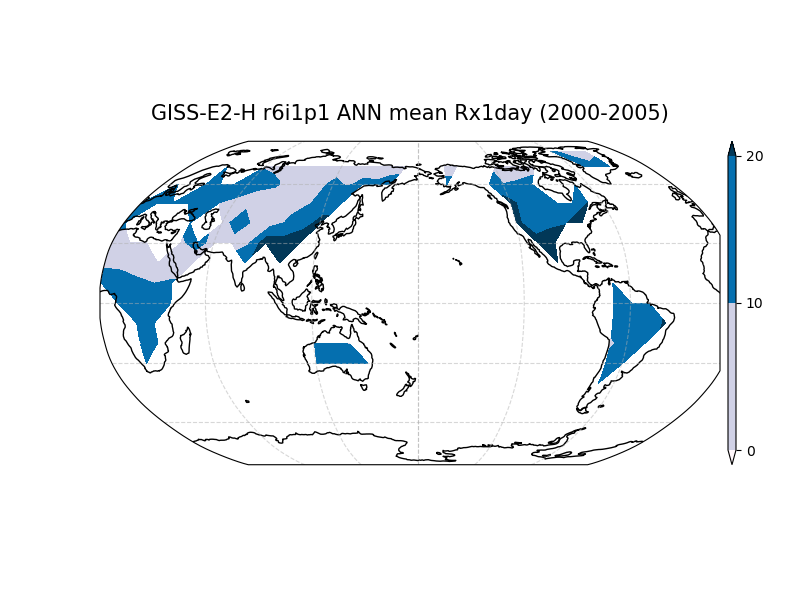

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(filename = demo_output_directory + "/extremes_ex3/plots/maps/GISS-E2-H_r6i1p1_land_Rx1day_ANN.png")

### Nonstationary Return Values

The examples in this notebook produce return values assuming that the data is stationary in time. The Extremes Driver also has an option to produce nonstationary return values for model data only.

To generate nonstationary return values, the user must provide two variables:

--covariate_path: Path to covariate time series netcdf file. The only dimension should be time, in years (with time bounds).  
--covariate: Name of covariate variable in file given by --covariate_path.  


This static example would run the driver with a covariate file "covariate_file.nc" that contains the variable "mole_fraction_or_carbon_dioxide_in_air":

```
extremes_driver.py -p basic_extremes_param.py --covariate_path ./covariate_file.nc --covariate "mole_fraction_of_carbon_dioxide_in_air"
```

### Regional metrics

Users can define a custom region over which to calculate the extremes metrics. There are two way to do this.

#### Coordinate method

The first method is to provide coordinate pairs that define a contiguous region. This region does not have to be rectangular, but it cannot have holes. 

The following example provides lon/lat pairs that define the western hemisphere. The region name flag "--region_name" is optional in this case.



In [13]:
%%bash
extremes_driver.py  -p basic_extremes_param.py \
--case_id "extremes_ex4" \
--plots \
--region_name "WestHemi" \
--coords [[180,-90],[360,-90],[360,90],[180,90]]

INFO::2023-10-19 11:59::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex4/GISS-E2-H_block_extremes_metrics.json
2023-10-19 11:59:09,911 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex4/GISS-E2-H_block_extremes_metrics.json
INFO::2023-10-19 11:59::pcmdi_metrics:: Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex4/block_extremes_metrics.json
2023-10-19 11:59:29,280 [INFO]: base.py(write:246) >> Results saved to a json file: /home/ordonez4/git/pcmdi_metrics/doc/jupyter/Demo/demo_output/extremes_ex4/block_extremes_metrics.json
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/pcmdi_metrics/extremes/lib/return_value.py:493: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(B))
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/sit

/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ordonez4/miniconda3/envs/pmp_climex_2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees

Region settings are:
  Coordinates: [[180.0, -90.0], [360.0, -90.0], [360.0, 90.0], [180.0, 90.0]]
  Region name: WestHemi
No sftlf file found for GISS-E2-H r6i1p1

-----------------------
model, run, variable: GISS-E2-H r6i1p1 pr
test_data (model in this case) full_path:
   demo_output/extremes_tmp/pr_day_GISS-E2-H_historical_r6i1p1_20000101-20051231.nc
Generating land sea mask.

Creating sftlf region mask.
Creating dataset mask.
Generating precipitation block extrema.
Writing results to netCDF.
Creating maps
Generating metrics.
Generating return values.
GISS-E2-H
Return value for multiple realizations
Stationary case
*****
 ANN 
*****
demo_output/extremes_ex4/netcdf/GISS-E2-H_r6i1p1_West_Rx5day_2000-2005.nc
demo_output/extremes_ex4/netcdf/GISS-E2-H_r6i1p1_WestHemi_Rx5day_2000-2005.nc
*****
 DJF 
*****
demo_output/extremes_ex4/netcdf/GISS-E2-H_r6i1p1_West_Rx5day_2000-2005.nc
demo_output/extremes_ex4/netcdf/GISS-E2-H_r6i1p1_WestHemi_Rx5day_2000-2005.nc
*****
 MAM 
*****
demo_output/ext

[WARNING] yaksa: 10 leaked handle pool objects


Viewing the automatic plots verifies that the region of interest has been used. Again, the contours will look rough because of the low spatial resolution of the demo data.

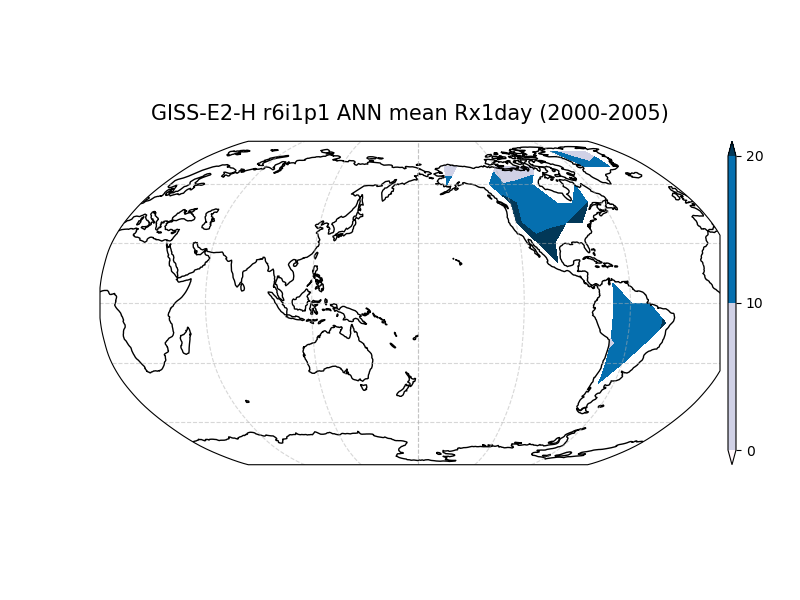

In [14]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(filename = demo_output_directory + "/extremes_ex4/plots/maps/GISS-E2-H_r6i1p1_West_Rx1day_ANN.png")

#### Shapefile method
The second method is to provide a shapefile containing the region of interest. The region of interest must be completely defined by a single, uniquely identifiable feature in the shapefile. For example, if the region of interest is the fifty states of the USA, there must be a single feature in the shapefile that contains all the land areas of all fifty states. The --region_name flag is required in this case.

--shp_path is the path of the shapefile containing your region  
--region_name must match the name of your region as recorded under the shapefile attribute "--attribute"

Here is a static example of a command to get metrics for a region called "CANADA" under the "COUNTRY" attribute in a shapefile called "world_countries.shp":  
```
extremes_driver.py -p basic_extremes_param.py --shp_path world_countries.shp --attribute "COUNTRY" --region_name "CANADA"
```

## Other options

Consult the [README file]() for the extremes metrics to find the full set of user options. 

## Clean up

Run this cell to delete the low resolution datasets we created at the start of this demo.

In [15]:
%%bash -s "$demo_output_directory"
rm -r $1/extremes_tmp